In [89]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [90]:
def Forecast(ARIMA_model, periods=48):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    # index_of_fc = pd.date_range(dataFrame.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='H')
    index_of_fc = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods = n_periods, freq="H")
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    return [fitted_series, lower_series, upper_series]

In [91]:
def AutoArima(x):
    return auto_arima(x, d=0, D=0, m=24,
                        seasonal = True, error_action = 'ignore')

In [92]:
def Plot(res, test):
    plt.figure(figsize=(15,4))
    plt.plot(res[0], color='darkgreen', label='Predict')
    plt.legend()
    plt.fill_between(res[1].index, 
                    res[1], 
                    res[2], 
                    color='k', alpha=.15)
    plt.title(test.columns.values)
    plt.plot(test, label='Data Train')
    plt.legend()
    plt.show()

In [93]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

## Sheet Mono

In [94]:
#Read Mono Series
dataFrame = pd.read_excel("DataAirTrain.xlsx",index_col=0,sheet_name="Mono")
dataFrame.head(5)


,Barometer,Radiation,WindDir,SO2,Compass,CO,O3,Wind Spd
time,,,,,,,,
2019-04-14 07:00:00,1010.28,0.01,188.88,19.17,264.66,461.82,-17.17,1.48
2019-04-14 08:00:00,1011.21,32.83,194.24,13.49,264.66,595.40,-3.70,1.55
2019-04-14 09:00:00,1012.36,311.73,108.60,6.68,265.00,553.42,3.09,1.24
2019-04-14 10:00:00,1012.66,532.91,119.74,5.77,265.00,446.55,8.60,1.78
2019-04-14 11:00:00,1012.78,610.51,116.88,5.72,265.00,435.10,33.08,1.56


In [95]:
#Fill null data with linear method and forward fill
dataFrame[['WindDir','SO2','CO','O3','Wind Spd']] = dataFrame[['WindDir','SO2','CO','O3','Wind Spd']].interpolate(method='linear')
dataFrame[['Compass']] = dataFrame[['Compass']].interpolate(method='pad')
dataFrame[['Radiation']] = dataFrame[['Radiation']].fillna(0)

In [96]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [97]:
trainSet = dataFrame[: -48]
testSet01 = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

<AxesSubplot:xlabel='time'>

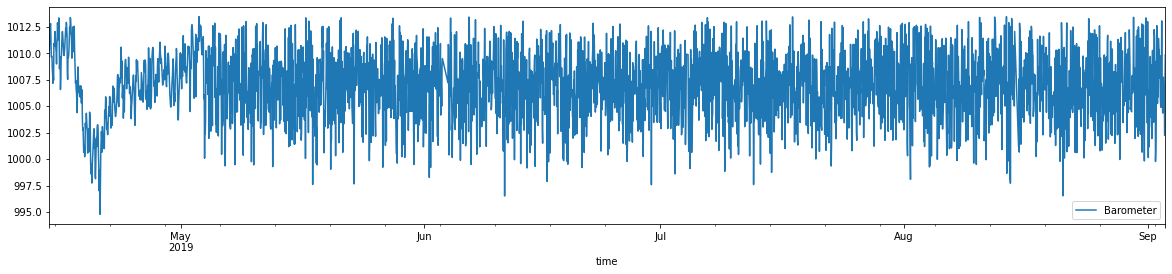

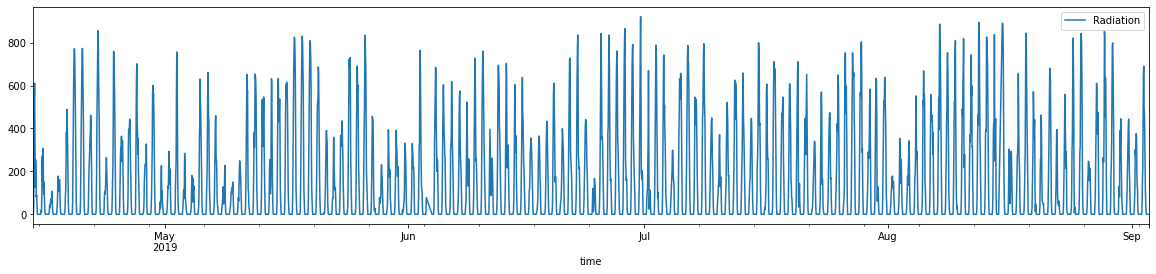

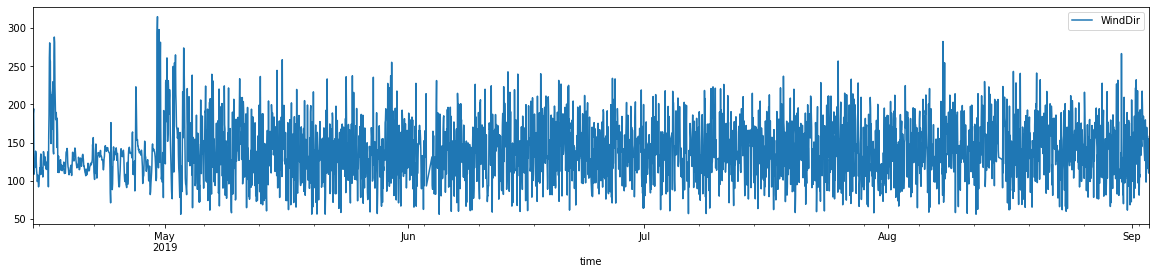

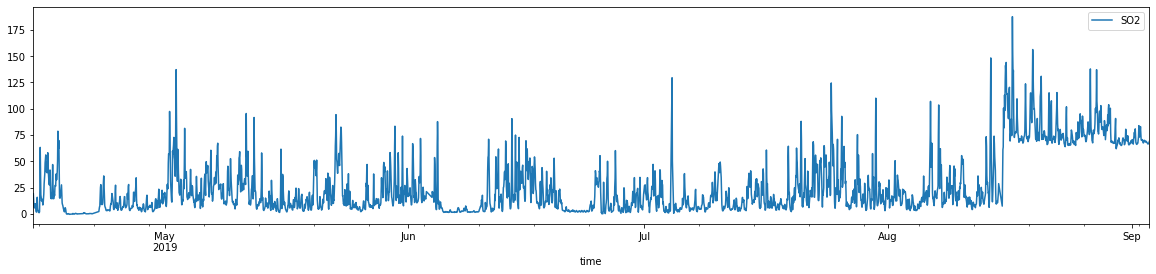

In [98]:
dataFrame[['Barometer']].plot(figsize=(20,4))
dataFrame[['Radiation']].plot(figsize=(20,4))
dataFrame[['WindDir']].plot(figsize=(20,4))
dataFrame[['SO2']].plot(figsize=(20,4))

In [99]:
len = 336
step = 48
resSarima = []
predict = []

In [100]:
resSarima.append(AutoArima(dataFrame['Barometer'].tail(len)))
resSarima.append(AutoArima(dataFrame['Radiation'].tail(len)))
resSarima.append(AutoArima(dataFrame['WindDir'].tail(len)))
resSarima.append(AutoArima(dataFrame['SO2'].tail(len)))

c:\Users\minhv\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


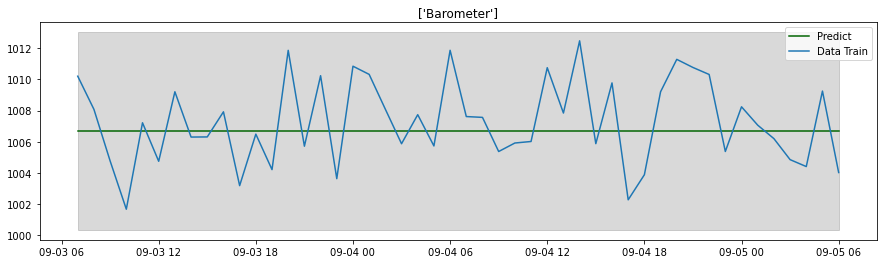

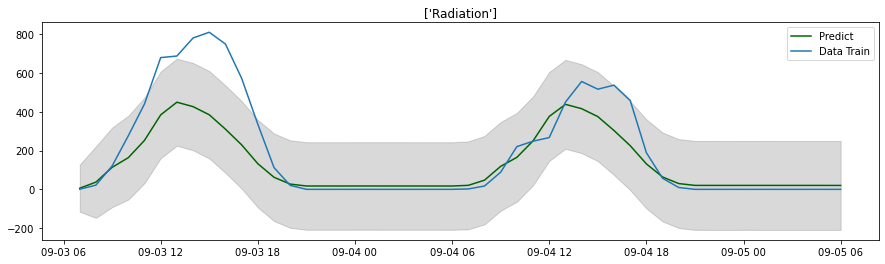

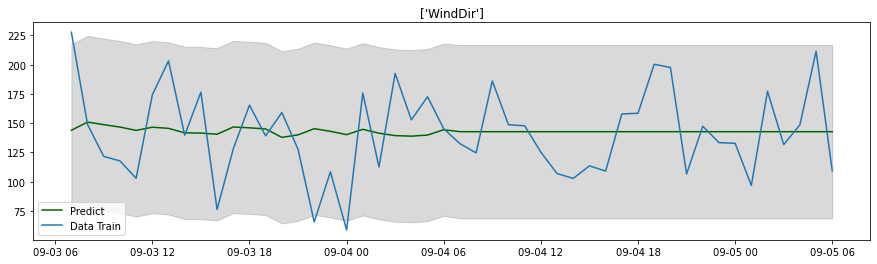

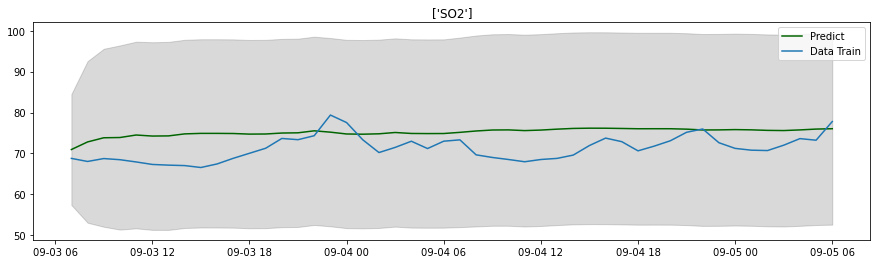

In [101]:
res = Forecast(resSarima[0])
Plot(res, testSet01[['Barometer']])
predict.append(res[0])

res = Forecast(resSarima[1])
Plot(res, testSet01[['Radiation']])
predict.append(res[0])

res = Forecast(resSarima[2])
Plot(res, testSet01[['WindDir']])
predict.append(res[0])

res = Forecast(resSarima[3])
Plot(res, testSet01[['SO2']])
predict.append(res[0])

# Sheet 4 Last Column

In [102]:
#Read Mono Series
dataFrame02 = pd.read_excel("DataAirTrain.xlsx",index_col=0,sheet_name="fourLastColumn")
dataFrame02 = dataFrame02.resample('H').interpolate(method='linear')

In [103]:
dataFrame02

,Hướng gió,Nhiệt độ,Áp suất khí quyển,Wind Spd (sai)
time,,,,
2019-04-30 23:00:00,127.740000,24.450000,1008.630000,0.550000
2019-05-01 00:00:00,127.177292,24.484583,1008.703333,0.549167
2019-05-01 01:00:00,126.614583,24.519167,1008.776667,0.548333
2019-05-01 02:00:00,126.051875,24.553750,1008.850000,0.547500
2019-05-01 03:00:00,125.489167,24.588333,1008.923333,0.546667
...,...,...,...,...
2019-09-05 02:00:00,103.960000,30.690000,1002.970000,2.460000
2019-09-05 03:00:00,84.250000,30.640000,1002.610000,2.570000
2019-09-05 04:00:00,74.200000,30.630000,1002.260000,3.080000


In [104]:
trainSet = dataFrame02[: -48]
testSet02 = dataFrame02[-48: ]
dataFrameCopy02 = dataFrame02
dataFrame02 = trainSet

In [105]:
len = 216
step = 48

In [106]:
resSarima.append(AutoArima(dataFrame02['Hướng gió'].tail(len)))
resSarima.append(AutoArima(dataFrame02['Nhiệt độ'].tail(len)))
resSarima.append(AutoArima(dataFrame02['Áp suất khí quyển'].tail(len)))
resSarima.append(AutoArima(dataFrame02['Wind Spd (sai)'].tail(len)))

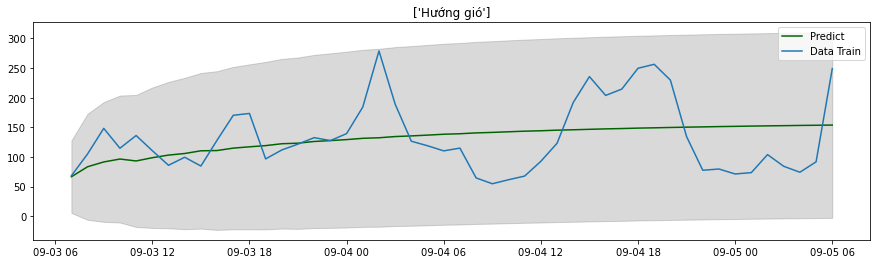

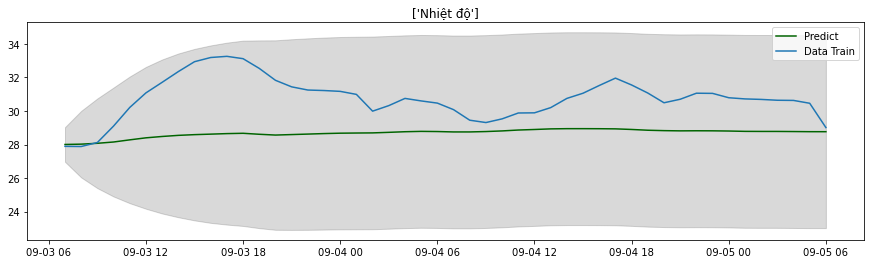

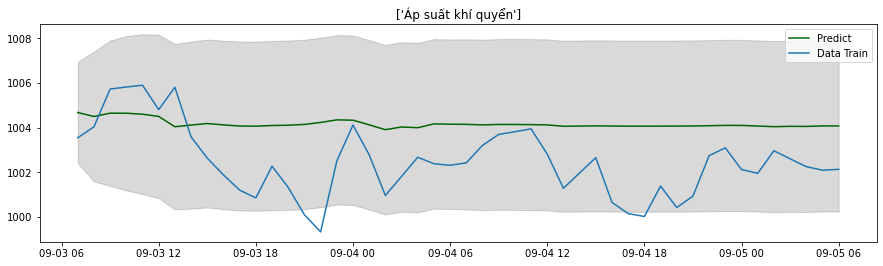

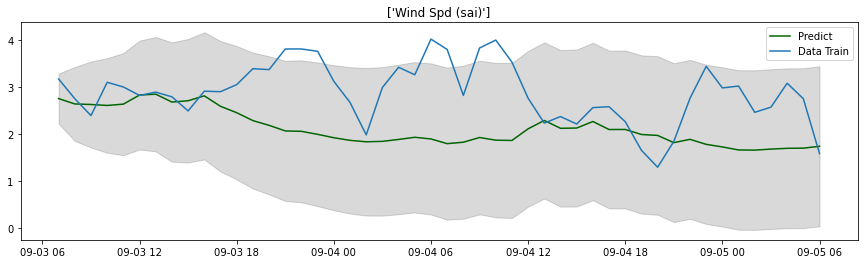

In [107]:
res = Forecast(resSarima[4])
Plot(res, testSet02[['Hướng gió']])
predict.append(res[0])

res = Forecast(resSarima[5])
Plot(res, testSet02[['Nhiệt độ']])
predict.append(res[0])

res = Forecast(resSarima[6])
Plot(res, testSet02[['Áp suất khí quyển']])
predict.append(res[0])

res = Forecast(resSarima[7])
Plot(res, testSet02[['Wind Spd (sai)']])
predict.append(res[0])

In [108]:
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
idx = pd.Index(dateTimeIndex, name='time')
dataFramePredicted = pd.DataFrame(predict)
dataFramePredicted = dataFramePredicted.transpose()
dataFramePredicted.index = idx
dataFramePredicted.columns = ["Barometer","Radiation","WindDir","SO2","Hướng gió","Nhiệt độ","Áp suất khí quyển","Wind Spd (sai)"]


In [109]:
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet01.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet01.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet01.iloc[:,2]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,3], testSet01.iloc[:,3]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,4], testSet02.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,5], testSet02.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,6], testSet02.iloc[:,2]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,7], testSet02.iloc[:,3]))
metric = pd.DataFrame(tmp, index=dataFramePredicted.columns.values)
print(metric)

C:\Users\minhv\AppData\Local\Temp\ipykernel_9768\105715035.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\minhv\AppData\Local\Temp\ipykernel_9768\105715035.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\minhv\AppData\Local\Temp\ipykernel_9768\105715035.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\minhv\AppData\Local\Temp\ipykernel_9768\105715035.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None

                       mape         me        mae       mpe        rmse  \
Barometer          0.002267  -0.578542   2.285402 -0.000567    2.753740   
Radiation               inf -60.610643  86.351046       inf  146.380881   
WindDir            0.246982   1.446436  30.113945  0.094631   37.181897   
SO2                0.061297   3.912173   4.286439  0.056522    4.806398   
Hướng gió          0.430179  -1.263429  48.481576  0.181925   59.034919   
Nhiệt độ           0.066252  -2.068330   2.078884 -0.065873    2.375971   
Áp suất khí quyển  0.001899   1.668363   1.902532  0.001666    2.200117   
Wind Spd (sai)     0.267338  -0.764717   0.835118 -0.223880    1.061130   

                           corr    minmax  
Barometer          3.694860e-14  0.002265  
Radiation          9.306778e-01  0.653815  
WindDir            2.221345e-02  0.186493  
SO2                3.525796e-01  0.056951  
Hướng gió          1.705043e-01  0.288174  
Nhiệt độ           3.559217e-01  0.066251  
Áp suất khí quyể